In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import GPyOpt, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from GPy import kern
from paramz import Model, Param

In [2]:
class ParamzLogReg(Model):
    def __init__(self, X, y, C=1.,n_components=3, rep= 1,name='ParamzLogReg'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzLogReg, self).__init__(name=name)

        self.X = X
        self.Y = y
        
        self.C = Param('C', C)
        self.n_components = Param('n_components', n_components)
        self.link_parameters(self.C,self.n_components)
        self.sk = [(tr_idx,test_idx) for tr_idx,test_idx in StratifiedKFold(train_labels, shuffle=True) for _ in range(rep)]
        
    def parameters_changed(self):
        from sklearn.metrics import accuracy_score
    
        self._acc = 0.
    
        for train_index, test_index in self.sk:
            pca = PCA(n_components=int(self.n_components.values))
            rfc = LogisticRegression(penalty='l2', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
            x_tr = pca.fit_transform(self.X[train_index])
            x_te = pca.transform(self.X[test_index])
            rfc = rfc.fit(x_tr, self.Y[train_index])
            prediction = rfc.predict(x_te)
            self._acc += accuracy_score(self.Y[test_index], prediction)/float(len(self.sk))
            
    def objective_function(self):
        import numpy as np
        print self._acc
        return -np.atleast_1d(self._acc)
    def predict(self, X):
        pca = PCA(n_components=int(self.n_components.values))
        rfc = LogisticRegression(penalty='l1', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
        x_tr = pca.fit_transform(self.X)
        x_te = pca.transform(X)
        rfc = rfc.fit(x_tr, self.Y)
        prediction = rfc.predict(x_te)
        return prediction
    def train(self):
        self.pca = PCA(n_components=int(self.n_components.values))
        self.rfc = LogisticRegression(penalty='l1', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
        x_tr = self.pca.fit_transform(self.X)
        self.rfc.fit(x_tr, self.Y)

    def predict_proba(self, X):
        x_te = self.pca.transform(X)
        prediction = self.rfc.predict_proba(x_te)
        return prediction

In [3]:
def proces_data(data,design):
    train_idx = design.Set == design.Set.unique()[0]
    test_idx = ~train_idx
    train_set = data.loc[:, train_idx]
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx]
    test_set[:] = normalizer.transform(test_set.T).T
    train_labels = design.loc[train_idx, 'Effect']
    test_labels = design.loc[test_idx, 'Effect']
    return train_idx, test_idx,train_set, test_set, train_labels, test_labels

# RNASEQ Data

In [4]:
%run load_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [5]:
data = rnaseq_all_genes
design = rnaseq_design
train_idx, test_idx,train_set, test_set, train_labels, test_labels = proces_data(data,design)

In [6]:
train_labels.head()

SampleID_RNASeq
RNAseq1    Control
RNAseq2    Control
RNAseq3    Control
RNAseq4    Control
RNAseq5    Control
Name: Effect, dtype: object

In [7]:
test_labels.head()

SampleID_RNASeq
RNAseq22     Control
RNAseq23    Effect_2
RNAseq24    Effect_2
RNAseq25    Effect_2
RNAseq26    Effect_6
Name: Effect, dtype: object

In [8]:
m = ParamzLogReg(train_set.T.values, train_labels.values, rep=1)

In [9]:
def f(X):
    ret = np.empty((X.shape[0],1))
    for i in range(X.shape[0]):
        ret[i] = m._objective(X[i])
    return ret
mixed_domain =[{'name': 'C', 'type': 'continuous', 'domain':(0.1,10)},
              {'name': 'n_components', 'type': 'discrete', 'domain':range(1,20)}]

m_opt = GPyOpt.methods.BayesianOptimization(f, 
                                            domain=mixed_domain,        # box-constrains of the problem
                                            initial_design_numdata = 10, # number data initial design
                                            kernel= kern.Matern32(input_dim=2, variance=1., lengthscale=(5,50), ARD=True) + kern.Bias(2),
                                            acquisition='EI',
                                            acquisition_par = 2,
                                            type_initial_design='latin')

0.870634920635
0.823015873016
0.677777777778
0.548412698413
0.548412698413
0.660317460317
0.854761904762
0.515873015873
0.418253968254
0.74126984127
*Optimization completed.


In [10]:
m_opt.run_optimization(60,                                   # evaluation budget
                                    eps=1e-5)

0.854761904762
0.838095238095
0.838095238095
0.870634920635
0.757936507937
0.854761904762
0.870634920635
0.870634920635
*Optimization completed.
   -Method converged.


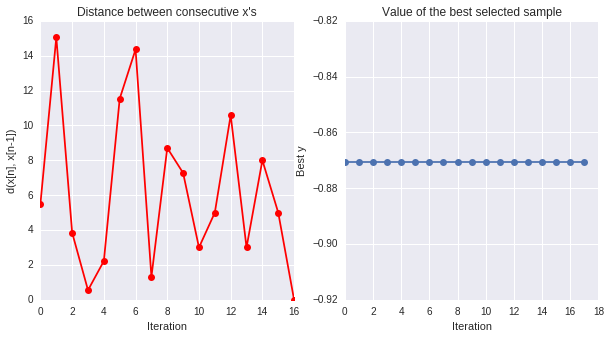

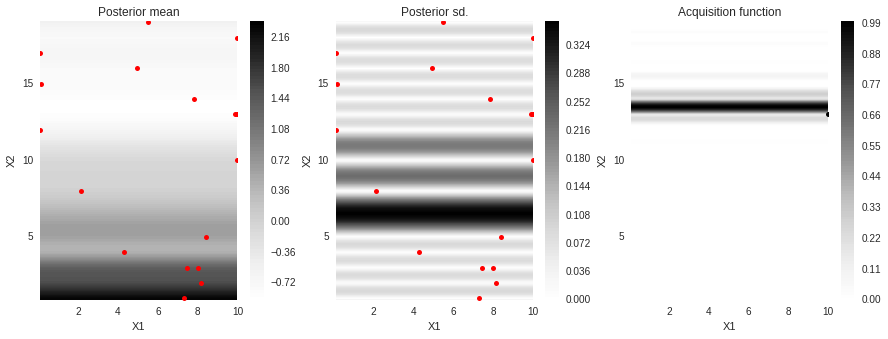

In [11]:
m_opt.plot_convergence()
m_opt.plot_acquisition()

In [12]:
m_opt.x_opt

array([  7.84221097,  14.        ])

In [13]:
m_opt.kernel

sum.,value,constraints,priors
Mat32.variance,1.06103269984,+ve,
Mat32.lengthscale,"(2,)",+ve,
bias.variance,2.33226762955e-15,+ve,


In [14]:
m.train()
prob_prediction = pd.DataFrame(m.predict_proba(test_set.T.values), columns=m.rfc.classes_, index=test_set.columns)
prob_prediction['Unknown']=0.
trans = prob_prediction>(1 - 1./6.)
trans.Unknown = np.sum(trans, axis=1) == 0 
prediction = trans.idxmax(axis=1)

In [15]:
trans.head()

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
RNAseq22,True,False,False,False,False,False,False
RNAseq23,False,False,True,False,False,False,False
RNAseq24,False,False,False,False,False,False,True
RNAseq25,False,False,False,False,True,False,False
RNAseq26,False,False,False,False,False,False,True


In [16]:
prediction.head()

RNAseq22     Control
RNAseq23    Effect_2
RNAseq24     Unknown
RNAseq25    Effect_4
RNAseq26     Unknown
dtype: object

In [17]:
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,8)]
true_labels = pd.DataFrame(np.zeros((test_labels.shape[0],8)), columns=col, index=test_set.columns)
for ind in test_labels.index:
    true_labels[test_labels[ind]][ind]=1
true_labels['Unknown'] = true_labels['Effect_6'] + true_labels['Effect_7']
del true_labels['Effect_6']
del true_labels['Effect_7']
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,6)] +['Unknown']
print np.sum(true_labels['Effect_3'])
true_labels.head()


0.0


,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
RNAseq22,1.0,0.0,0.0,0.0,0.0,0.0,0.0
RNAseq23,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RNAseq24,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RNAseq25,0.0,0.0,1.0,0.0,0.0,0.0,0.0
RNAseq26,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [19]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(7):
    precision[col[i]], recall[col[i]], _ = precision_recall_curve(true_labels.values[:, i],
                                                        prob_prediction.values[:, i])
    average_precision[col[i]] = average_precision_score(true_labels.values[:, i], prob_prediction.values[:, i])


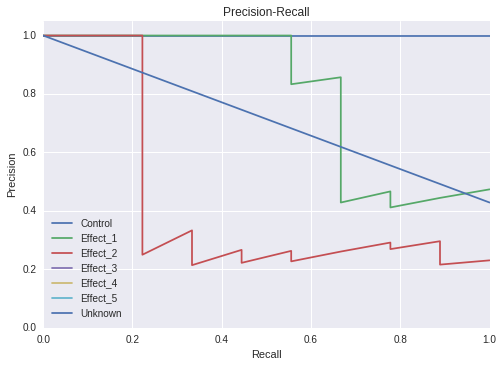

In [20]:
k = col[0]
plt.clf()
for k in col:
    plt.plot(recall[k], precision[k], label='{0}'.format( k))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.show()


In [21]:
from sklearn.metrics import classification_report, accuracy_score
print classification_report(true_labels.idxmax(axis=1), prediction.values)
print accuracy_score(true_labels.idxmax(axis=1), prediction.values)

             precision    recall  f1-score   support

    Control       1.00      0.67      0.80         6
   Effect_1       0.83      0.56      0.67         9
   Effect_2       1.00      0.22      0.36         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.61      0.78      0.68        18

avg / total       0.80      0.60      0.63        42

0.595238095238


In [22]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(true_labels.idxmax(axis=1), prediction, labels= true_labels.columns), columns=true_labels.columns, index=true_labels.columns)

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Control,4,0,0,0,0,0,2
Effect_1,0,5,0,0,0,0,4
Effect_2,0,0,2,0,4,0,3
Effect_3,0,0,0,0,0,0,0
Effect_4,0,0,0,0,0,0,0
Effect_5,0,0,0,0,0,0,0
Unknown,0,1,0,2,1,0,14


# Micro rna

In [23]:
%run load_data.py micro

loading microarray data
micro_all_genes: (13613, 105)
micro_effector_genes: (1044, 105)
micro_mod_activities: (89, 105)
micro_mod_genevals: (201, 105)
micro_mod_nodevals: (462, 105)
micro_signaling_genes: (2184, 105)
micro_design: (105, 4)


In [24]:
data = micro_all_genes
design = micro_design
train_idx, test_idx,train_set, test_set, train_labels, test_labels = proces_data(data,design)

In [25]:
train_set = data.loc[:, train_idx]
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
train_set[:] = normalizer.fit_transform(train_set.T).T

test_set = data.loc[:, test_idx]
test_set[:] = normalizer.transform(test_set.T).T

In [26]:
train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']
test_labels.head()
design.head()

,idx,Effect,Drug/Chemical,Set
SampleID_Microarray,,,,
Array_1,1,Effect_3,Drug/Chemical_1,Training Set
Array_2,2,Effect_3,Drug/Chemical_1,Training Set
Array_3,3,Effect_3,Drug/Chemical_2,Training Set
Array_4,4,Effect_3,Drug/Chemical_2,Training Set
Array_5,5,Effect_3,Drug/Chemical_2,Training Set


In [27]:
m = ParamzLogReg(train_set.T.values, train_labels.values, rep=1)

In [28]:
def f(X):
    ret = np.empty((X.shape[0],1))
    for i in range(X.shape[0]):
        ret[i] = m._objective(X[i])
    return ret
mixed_domain =[{'name': 'C', 'type': 'continuous', 'domain':(0.1,10)},
              {'name': 'n_components', 'type': 'discrete', 'domain':range(1,20)}]

m_opt = GPyOpt.methods.BayesianOptimization(f, 
                                            domain=mixed_domain,        # box-constrains of the problem
                                            initial_design_numdata = 10, # number data initial design
                                            kernel= kern.Matern32(input_dim=2, variance=1., lengthscale=(5,50), ARD=True) + kern.Bias(2),
                                            acquisition='EI',
                                            acquisition_par = 2,
                                            type_initial_design='latin')

0.365079365079
0.492063492063
0.428571428571
0.492063492063
0.555555555556
0.634920634921
0.492063492063
0.507936507937
0.555555555556
0.47619047619
*Optimization completed.


In [29]:
m_opt.run_optimization(60,                                   # evaluation budget
                                    eps=1e-5)

0.619047619048
0.269841269841
0.507936507937
0.650793650794
0.301587301587
0.47619047619
0.634920634921
0.460317460317
0.634920634921
0.634920634921
0.634920634921
*Optimization completed.
   -Method converged.


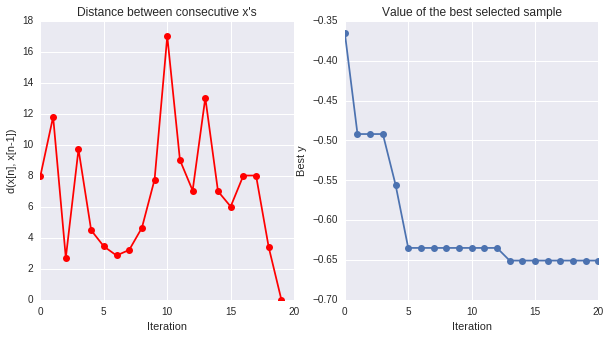

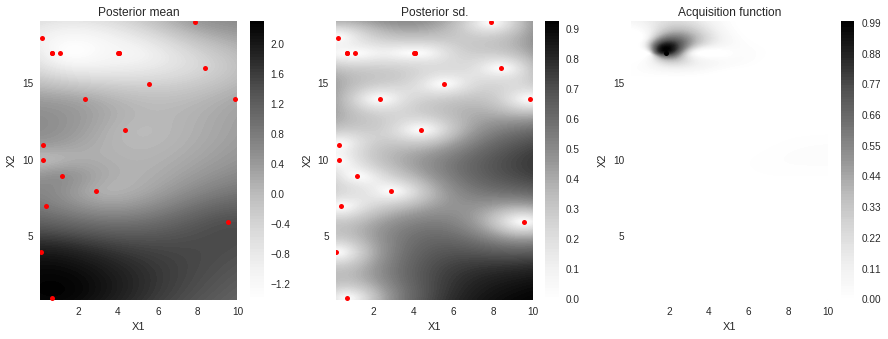

In [30]:
m_opt.plot_convergence()
m_opt.plot_acquisition()

In [31]:
print 1/600.
m_opt.x_opt

0.00166666666667


array([  1.06559226,  17.        ])

In [32]:
m_opt.kernel

sum.,value,constraints,priors
Mat32.variance,0.903801033508,+ve,
Mat32.lengthscale,"(2,)",+ve,
bias.variance,0.440533303464,+ve,


In [33]:
m.train()
prob_prediction = pd.DataFrame(m.predict_proba(test_set.T.values), columns=m.rfc.classes_, index=test_set.columns)
prob_prediction['Unknown']=0.
trans = prob_prediction>(1 - 1./6.)
trans.Unknown = np.sum(trans, axis=1) == 0 
prediction = trans.idxmax(axis=1)

In [34]:
trans.head()

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Array_10,False,False,False,True,False,False,False
Array_11,False,False,False,False,False,False,True
Array_12,True,False,False,False,False,False,False
Array_13,False,False,False,False,False,False,True
Array_14,False,False,False,False,False,False,True


In [35]:
prediction.head()

Array_10    Effect_3
Array_11     Unknown
Array_12     Control
Array_13     Unknown
Array_14     Unknown
dtype: object

In [36]:
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,8)]
true_labels = pd.DataFrame(np.zeros((test_labels.shape[0],8)), columns=col, index=test_set.columns)
for ind in test_labels.index:
    true_labels[test_labels[ind]][ind]=1
true_labels['Unknown'] = true_labels['Effect_6'] + true_labels['Effect_7']
del true_labels['Effect_6']
del true_labels['Effect_7']
col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,6)] +['Unknown']
print np.sum(true_labels['Effect_3'])
true_labels.head()


0.0


,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Array_10,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_11,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_12,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_13,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Array_14,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [38]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(7):
    precision[col[i]], recall[col[i]], _ = precision_recall_curve(true_labels.values[:, i],
                                                        prob_prediction.values[:, i])
    average_precision[col[i]] = average_precision_score(true_labels.values[:, i], prob_prediction.values[:, i])


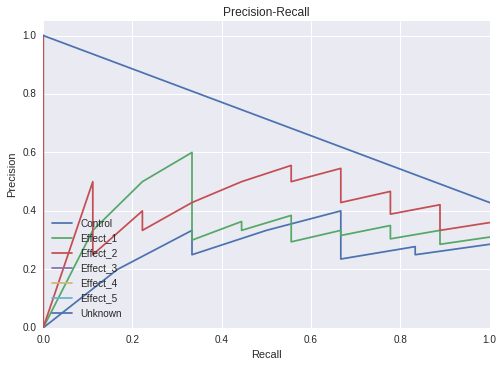

In [39]:
k = col[0]
plt.clf()
for k in col:
    plt.plot(recall[k], precision[k], label='{0}'.format( k))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.show()


In [40]:
from sklearn.metrics import classification_report, accuracy_score
print classification_report(true_labels.idxmax(axis=1), prediction.values)
print accuracy_score(true_labels.idxmax(axis=1), prediction.values)

             precision    recall  f1-score   support

    Control       0.29      0.33      0.31         6
   Effect_1       0.50      0.22      0.31         9
   Effect_2       0.00      0.00      0.00         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
   Effect_5       0.00      0.00      0.00         0
    Unknown       0.39      0.39      0.39        18

avg / total       0.31      0.26      0.28        42

0.261904761905


In [41]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(true_labels.idxmax(axis=1), prediction, labels= true_labels.columns), columns=true_labels.columns, index=true_labels.columns)

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5,Unknown
Control,2,0,0,0,1,0,3
Effect_1,1,2,1,2,1,0,2
Effect_2,2,0,0,1,0,0,6
Effect_3,0,0,0,0,0,0,0
Effect_4,0,0,0,0,0,0,0
Effect_5,0,0,0,0,0,0,0
Unknown,2,2,0,5,0,2,7
